In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qutip import * 
import os

# Matplotlib Einstellungen gemäß den LaTeX-Caption-Formatierungen
plt.rcParams.update({
#    'text.usetex': True,              # Enable LaTeX for text rendering
#    'font.family': 'serif',           # Use a serif font family
#    'font.serif': 'Palatino',         # Set Palatino as the serif font
#    'text.latex.preamble': r'\usepackage{amsmath}',
#    'font.size': 20,                   # Font size for general text
#    'axes.titlesize': 20,              # Font size for axis titles
#    'axes.labelsize': 20,              # Font size for axis labels
#    'xtick.labelsize': 20,             # Font size for x-axis tick labels
#    'ytick.labelsize': 20,             # Font size for y-axis tick labels
#    'legend.fontsize': 20,             # Font size for legends
#    'figure.figsize': [8, 6],          # Size of the plot (width x height)
#    'figure.autolayout': True,         # Automatic layout adjustment
#    'savefig.format': 'svg',           # Default format for saving figures
#    'figure.facecolor': 'none',        # Make the figure face color transparent
#    'axes.facecolor': 'none',          # Make the axes face color transparent
#    'savefig.transparent': True        # Save figures with transparent background
})
output_dir = r"C:\Users\leopo\OneDrive - UT Cloud\Uni\Semester_9\Master_thesis\Figures_From_Python"
os.makedirs(output_dir, exist_ok=True)

# allows for interactive plots
#%matplotlib notebook

$$
H = H_0 + H_I
$$
$$
H_0 = \hbar  \omega_a \sum_{i=1}^{N_{\text{atoms}}} \sigma_+^{(i)} \sigma_-^{(i)}
+ \hbar \sum_{i,j=1}^{N_\text{{atoms}}} J_{i j} \sigma_+^{(i)} \sigma_-^{(j)}
$$

$$
H_I = \hbar \Sigma_x E(t).
$$

$$
\displaystyle J_{i j} = \frac{\alpha}{|r_i-r_j|}.
$$

In [113]:
# Set the system parameters
n_rings = 1
n_chains = 1 # number of chains
N_atoms = n_chains * n_rings  # number of atoms

fixed_lam = 1.                # energysplitting of the atom, when ground state is set to 0
omega_a = 2 * np.pi / fixed_lam # actually k_a
omega_c = omega_a
distance = 1 * fixed_lam # defining topology                                    0.1 <--

gamma_0 = .1   # decay rate of the atoms
gamma_phi = .0 # dephasing rate of the atoms

alpha = 1. # coupling strength of the dipoles       Fine structure const?

# evolution
t_max = 10
time_steps = 100
t_step_width = t_max / time_steps
times = np.linspace(0, t_max, time_steps) # list of times

In [114]:
########################################               define the geometry                 #############################################
def chain_positions(distance, N_atoms):
    Pos = np.zeros((N_atoms, 3))
    for i in range(N_atoms):
        Pos[i, 2] = i * distance
    return Pos

def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0,              0,            1]])

def ring_positions(distance, n_chains):
    Pos = np.zeros((n_chains, 3))
    dphi = 2 * np.pi / n_chains
    if n_chains == 1:
        radius = 0
    else:
        radius = distance / 2 / np.sin(np.pi / n_chains)
    helper = np.array([radius, 0, 0])
    for i in range(n_chains):
        rotation_matrix = z_rotation(dphi * i)
        Pos[i] = np.matmul(rotation_matrix, helper)
    return Pos

def cyl_positions(distance, N_atoms, n_chains):
    Pos = np.zeros((N_atoms, 3))
    Pos_chain = chain_positions(distance, N_atoms // n_chains)
    Pos_ring = ring_positions(distance, n_chains)
    for i in range(n_chains):
        Pos[i * (N_atoms // n_chains): (i + 1) * (N_atoms // n_chains)] = Pos_chain + Pos_ring[i]
    return Pos

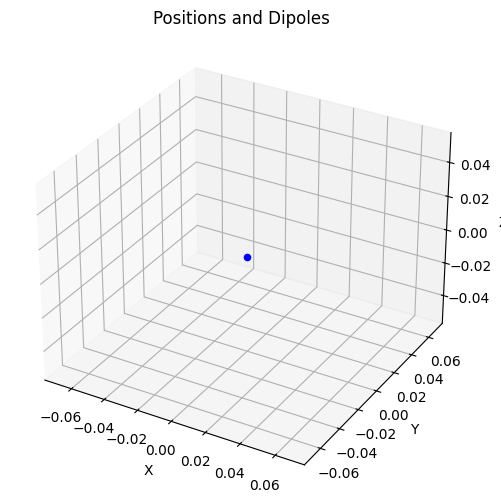

In [115]:
Pos = cyl_positions(distance, N_atoms, n_chains)

# Plotting 
fig = plt.figure(figsize=(8, 6)) 
ax = fig.add_subplot(111, projection='3d') 
# Plot the positions 
ax.scatter(Pos[:, 0], Pos[:, 1], Pos[:, 2], c='b', marker='o') 
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Positions and Dipoles')
ax.axis('equal')
plt.show()

In [116]:
# Define the ground & the excited states
# atomic dofs
atom_g = basis(N_atoms + 1, 0)
atom_es = [basis(N_atoms + 1, i) for i in range(1, N_atoms + 1)]

# combined dofs
sm_list = []    # lowering operators of atomic system
S_x = 0         # collective sigma_x operator for the system

for i in range(N_atoms):
    op = atom_g * atom_es[i].dag()
    sm_list.append(op)
    S_x += op + op.dag()

In [117]:
def Hamilton0(distance, n_rings, n_chains):
    N_atoms = n_chains * n_rings
    Pos = cyl_positions(distance, N_atoms, n_chains)
    H = 0
    for a in range(N_atoms):
        for b in range(N_atoms):
            op = sm_list[a].dag() * sm_list[b]
            if a != b:
                ra, rb = Pos[a, :], Pos[b, :]
                H += alpha / (np.linalg.norm(rb-ra)) * op
            else:
                H += omega_a * op # Diagonals except for |0><0|
    return H
    
H0 = Hamilton0(distance, n_rings, n_chains)

H0

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.         0.        ]
 [0.         6.28318531]]

## Single case

$$
C_{\text{decay}}^{(i)} = \sqrt{\gamma_0} \sigma_-^{(i)} \quad
C_{\text{dephase}}^{(i)} = \sqrt{\gamma_\phi} \sigma_z^{(i)}
$$

## Collective case
$$
C_{\text{decay}} = \sum_{n=1}^{N_{\text{atoms}}} C_{\text{decay}}^{(i)} \quad
C_{\text{dephase}} = \sum_{n=1}^{N_\text{atoms}} C_{\text{dephase}}^{(i)}
$$

In [118]:
# Jump / Expect Operators
# Define the decay collapse and dephasing operator for each spin

op_list = sm_list  # Operators combining the cavity (qeye(2)) and the atomic lowering operator (sm)

# Collapse operators
c_op2 = [np.sqrt(gamma_0) * op for op in op_list]                         # Individual atom decays
c_op4 = [np.sqrt(gamma_phi) * commutator(op.dag(), op) for op in op_list] # Individual atom dephasing
c_op_list = c_op2 + c_op4  # Combine all collapse operators

# Expectation operators for measuring populations across atomic excited levels
e_op_list = [
    basis(N_atoms + 1, i) * basis(N_atoms + 1, i).dag()
    for i in range(N_atoms + 1)
]

In [119]:
# create the time dependant evolution

I = S_x
E12 = 10 # Amplitude of laser pulses 1,2
E0s = [E12, E12, E12/10] # Probe pulse is smaller
omegas = [omega_a, omega_a, omega_a]
Delta_ts = [t_max/300, t_max/300, t_max/300] # narrow width of the pulses
phi12 = 2  * np.pi         # phis = [phi12, phi12, 0]  # Phase-kick?, pulse 1 and 2 are phase locked!

def heaviside(x):
    return 1 if x >= 0 else 0

def El_field(t, args):
    t0 = args['time']
    Delta = args['Delta']
    E = 1 / np.sqrt(2) * args['E0'] * heaviside(Delta - np.abs(t - t0)) * np.cos(np.pi*(t - t0)/(2*Delta))**2 * np.cos(args['omega'] * (t - t0) + args['phi'])
    return E

HI = [I, El_field] # interaction Hamiltonian with function-based time dependence
H = [H0, HI]

options = Options(store_states=True)

/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


In [120]:
# evolution with t
# initial state
psiini = basis(N_atoms+1, 0) # = |g>_atom

#
# PREPROCESSING
#
# Define the phases, coherence times, and waiting times
phases = [i * np.pi/2 for i in range(4)]

# Initialize the main dictionary to hold the structure
data_dict = {}
data_dict_stage1 = {}
data_dict_stage2 = {}

# Loop through each phase φ
for phi in phases:
    # Create a subdictionary for each phase
    data_dict[phi] = {}
    data_dict_stage1[phi] = {}  # Stage 1 copy of the phase
    data_dict_stage2[phi] = {}  # Stage 2 copy of the phase

# Print the resulting nested dictionary structure
import pprint
pprint.pprint(data_dict)

{0.0: {}, 1.5707963267948966: {}, 3.141592653589793: {}, 4.71238898038469: {}}


In [121]:
# (first laser pulse)
times_0 = times

# Iterate over the phi values
for phi in data_dict_stage1:
    args_0 = {
        'phi': phi12,  # Use the phase from data_dict_stage1
        'time': Delta_ts[0],  # t0 value = Delta value such that the pulse immediatley starts
        'omega': omegas[0],  # omega value
        'Delta': Delta_ts[0], # The width should be
        'E0': E0s[0]  # E0 value
    }

    # Solve the system using mesolve (first laser pulse)
    result_0 = mesolve(H, psiini, times_0, c_ops=c_op_list, args=args_0, options=options)

    current_dict = {}

    for i in range(len(times_0)): # save only the states that make sense
        if (2 * (Delta_ts[0]) <= times_0[i] <= t_max - 2 * (Delta_ts[1] + Delta_ts[2])):
            current_dict[i] = result_0.states[i]  # tau is indirectly stored in the index i (key of the dictionary)

    if current_dict:  # Check if the dictionary is not empty
        data_dict_stage1[phi] = current_dict

#pprint.pprint(data_dict_stage1)

In [122]:
# (second laser pulse)
# Iterate over the phi values
for phi, dic in data_dict_stage1.items():
    args_1 = {
        'phi': phi12,
        'time': Delta_ts[1],
        'omega': omegas[1],
        'Delta': Delta_ts[1],
        'E0': E0s[1]
    }

    # Iterate over the tau values and states after tau, from there make the second laser pulse
    for i, psiini_1 in dic.items():
        times_1 = times[i:]
        # Solve the system using mesolve (second laser pulse)
        result_1 = mesolve(H, psiini_1, times_1, c_ops=c_op_list, args=args_1, options=options)

        current_dict = {}
        for j in range(len(times_1)): # save only the states that make sense
            if (times[i] + 2 * (Delta_ts[1]) <= times_1[j] <= t_max - 2 * (Delta_ts[2])):
                current_dict[j] = result_1.states[j] # T is stored in the information j, together with i

        if current_dict:  # Check if the dictionary is not empty
            data_dict_stage2[phi][i] = current_dict

# After processing each coherence time, you can optionally print the current state of the dictionary
#pprint.pprint(data_dict_stage2)

In [ ]:
# (third laser pulse)
data_dict = {}

# Iterate over the phi values
for phi, dic in data_dict_stage2.items():
    args_2 = {
        'phi': 0,       #last pulse has no phase kick
        'time': Delta_ts[2],  # Duration for the 2nd pulse
        'omega': omegas[2],  # Omega for the 2nd pulse
        'Delta': Delta_ts[2],  # Delta for the 2nd pulse
        'E0': E0s[2]  # E0 for the 2nd pulse
    }

    # Iterate over the tau values
    for i, dic1 in dic.items():
        coherence_time_i = times[i] - Delta_ts[0] + Delta_ts[1]

        # Iterate over the T values and make the last laser pulse
        for j, psiini_2 in dic1.items():

             if i <= j - 2 * (Delta_ts[2]) / t_step_width:
                times_2 = times[j:]
                # (last laser pulse)
                result_2 = mesolve(H, psiini_2, times_2, c_ops=c_op_list, args=args_2, options=options)

                waiting_time_j = times[j] - times[i] + Delta_ts[2] - Delta_ts[1]

                # Iterate over the states in result_2 and store the ones that meet:
                # ONLY the first state with T >= times_2[0] + 2 Delta_ts[2] is important -> break
                for k in range(len(times_2)):
                    if (times[j] + 2 * Delta_ts[2] <= times_2[k] and times_2[k] <= t_max):
                        if phi not in data_dict:
                            data_dict[phi] = {}
                        if coherence_time_i not in data_dict[phi]:
                            data_dict[phi][coherence_time_i] = {}
                        if waiting_time_j not in data_dict[phi][coherence_time_i]:
                            data_dict[phi][coherence_time_i][waiting_time_j] = []

                        # store the final time and the final state
                        data_dict[phi][coherence_time_i][waiting_time_j].append((times_2[k], result_2.states[k]))

#                        break  # Stop after saving the first v pair

pprint.pprint(data_dict)
# The final data_dict will now contain the results for each φ, τ, and T

In [101]:
# Create an empty dictionary `accumulated_data` to store lists of (\psi) for each ((\tau, T, t)):
accumulated_data = {}

for phi, phi_dict in data_dict.items():
    for tau, tau_dict in phi_dict.items():
        for T, T_list in tau_dict.items():
            for t, psi in T_list:

                # Create a key for the current combination
                key = (tau, T, t)
                # Add psi to the list for this combination
                if key not in accumulated_data:
                    accumulated_data[key] = []
                accumulated_data[key].append(psi)

# After accumulating all states (( \psi )) for each ((\tau, T, t)), compute the average and then also the expectation value
# <psi | S_x | psi>
averaged_data_dict = {}

for (tau, T, t), states in accumulated_data.items():
    # Compute the average of the states
    mean_psi = sum(states) / len(states)
    expect_val = expect(S_x, mean_psi)

    # Save the result in averaged_data_dict
    if T not in averaged_data_dict:
        averaged_data_dict[T] = {}
    if tau not in averaged_data_dict[T]:
        averaged_data_dict[T][tau] = {}
    averaged_data_dict[T][tau][t] = expect_val

averaged_data_dict

# this is already in the order:
#     averaged_data_dict = {
#         T1: {
#             tau1: {t: avg},
#             tau2: {t: avg},
#             ...
#         },
#         T2: { ... }
#         ...
#     }
# here T1<T2<... and for each case tau1<tau2<... aswell as t1<t2<...
# for a fixed T: taui directly correponds to ti for which i runs from 0 to Steps = time_steps - T_steps = time_steps * (1 - T/t_max)

{np.float64(1.1111111111111112): {np.float64(1.1111111111111112): {np.float64(3.3333333333333335): -0.1912617451160123,
   np.float64(4.444444444444445): 0.04851685979368562,
   np.float64(5.555555555555555): 0.24145992301154603,
   np.float64(6.666666666666667): 0.3065129832206162,
   np.float64(7.777777777777779): 0.22815359376424676,
   np.float64(8.88888888888889): 0.056389281408044015,
   np.float64(10.0): -0.1224201316760681},
  np.float64(2.2222222222222223): {np.float64(4.444444444444445): 0.24145822589201052,
   np.float64(5.555555555555555): 0.30653144559483636,
   np.float64(6.666666666666667): 0.2281839107109074,
   np.float64(7.777777777777779): 0.056406576164398106,
   np.float64(8.88888888888889): -0.12243587982420101,
   np.float64(10.0): -0.2279063458163666},
  np.float64(3.3333333333333335): {np.float64(5.555555555555555): 0.22817254866364636,
   np.float64(6.666666666666667): 0.05640756336349775,
   np.float64(7.777777777777779): -0.12242233432255581,
   np.float64(8

In [107]:
# Initialize a dictionary to hold the 2D arrays
two_d_array_dict = {}

# Process each T in averaged_data_dict
for T, tau_dict in averaged_data_dict.items():
    T = round(T, 10)  # Round T to 10 decimal places TODO carefull!
    # Extract and sort unique taus and ts
    taus = sorted(tau_dict.keys())  # Unique sorted taus
    ts = sorted(next(iter(tau_dict.values())).keys())  # Unique sorted ts (assumes all taus have same t structure)

    # Create a 2D array filled with zeros
    values_array = np.zeros((len(taus), len(ts)))

    # Populate the 2D array with expect_val values
    for i, tau in enumerate(taus):
        for j, t in enumerate(ts):
            # Fetch the value for (tau, t) if available
            if t in tau_dict[tau]:
                values_array[i, j] = tau_dict[tau][t]

    # Store the 2D array in the dictionary for this T
    two_d_array_dict[T] = values_array

# Now, two_d_array_dict contains the 2D arrays for each T filled with zeros by default
two_d_array_dict

{np.float64(1.1111111111): array([[-0.19126175,  0.04851686,  0.24145992,  0.30651298,  0.22815359,
          0.05638928, -0.12242013],
        [ 0.        ,  0.24145823,  0.30653145,  0.22818391,  0.05640658,
         -0.12243588, -0.22790635],
        [ 0.        ,  0.        ,  0.22817255,  0.05640756, -0.12242233,
         -0.22788797, -0.22072023]]),
 np.float64(2.2222222222): array([[ 0.0564037 , -0.12242141, -0.22788695, -0.22071873]]),
 np.float64(3.3333333333): array([[ 0.22816763,  0.05640242, -0.12242539, -0.2278878 ]]),
 np.float64(4.4444444444): array([[ 0.3064906 ,  0.22814889,  0.05638826, -0.12241671],
        [ 0.        ,  0.0563997 , -0.1224248 , -0.22788828]]),
 np.float64(5.5555555556): array([[ 0.22813837,  0.05638953, -0.12241789]]),
 np.float64(6.6666666667): array([[ 0.05638656, -0.12241723]])}

[[ 0.76313827+0.j         -1.15246102-1.90256447j -0.09355216-0.03975624j
   0.19502794+0.0448418j   0.19502794-0.0448418j  -0.09355216+0.03975624j
  -1.15246102+1.90256447j]
 [ 0.46945701-0.66570365j -0.74460088+0.61166108j -0.34282861-0.01849938j
  -0.29025166+0.11988598j -0.07861357+0.18233023j  0.10694951+0.01700917j
  -0.45894402-0.24668343j]
 [ 0.46945701+0.66570365j -0.45894402+0.24668343j  0.10694951-0.01700917j
  -0.07861357-0.18233023j -0.29025166-0.11988598j -0.34282861+0.01849938j
  -0.74460088-0.61166108j]]
[[-0.51462338+0.j          0.28429065-0.09829732j  0.17165689+0.j
   0.28429065+0.09829732j]]
[[-0.06574313+0.j          0.35059302-0.28429022j  0.27722762+0.j
   0.35059302+0.28429022j]]
[[0.17469766+0.j         0.37252713-0.63485358j 0.30621046+0.j
  0.37252713+0.63485358j]
 [0.76252442+0.j         0.12767753-0.06627762j 0.2080829 +0.j
  0.12767753+0.06627762j]]
[[0.16211   +0.j         0.26115255-0.15485176j 0.26115255+0.15485176j]]
[[-0.06603067+0.j  0.17880379+0.j]

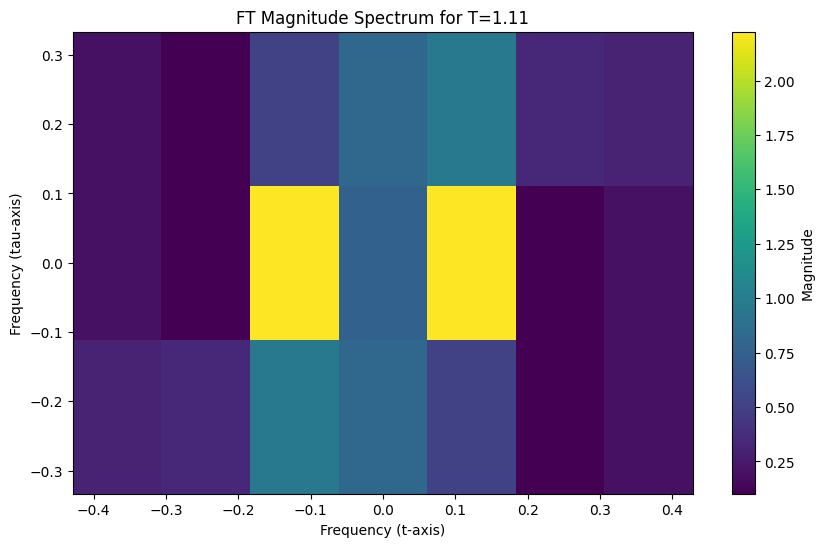

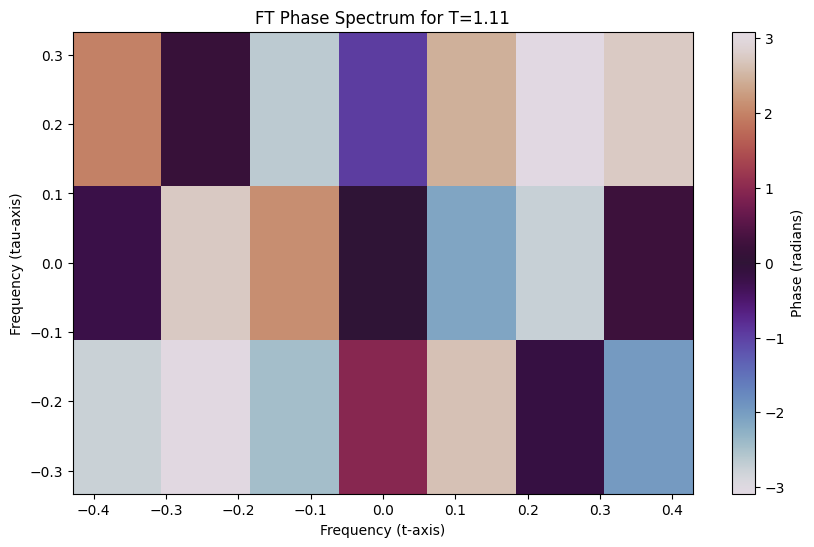

/tmp/ipykernel_92846/2243804121.py:35: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(


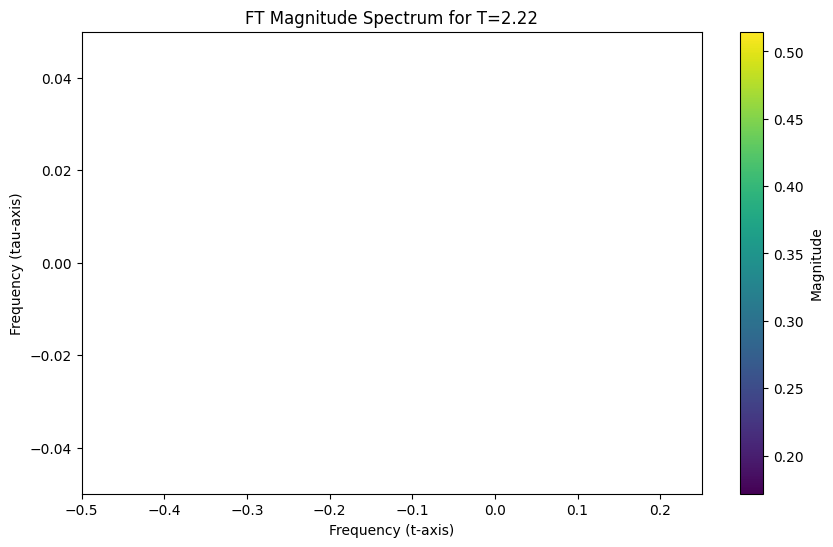

/tmp/ipykernel_92846/2243804121.py:50: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(


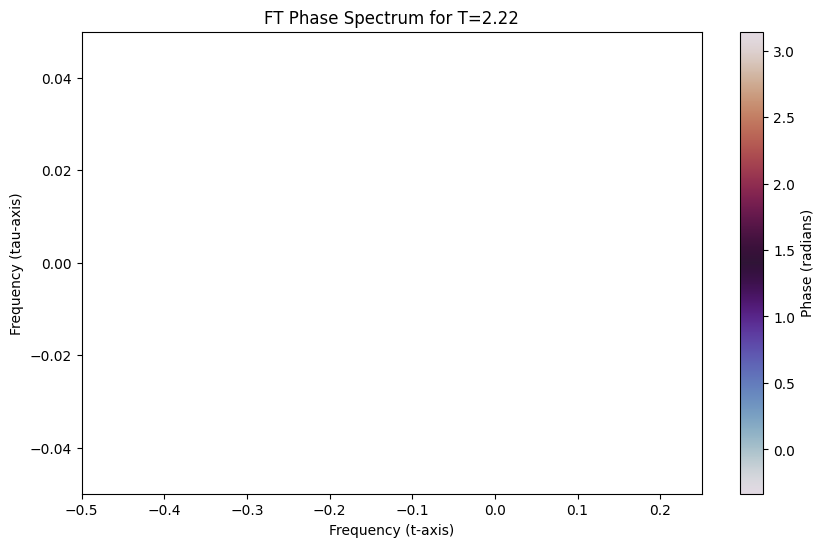

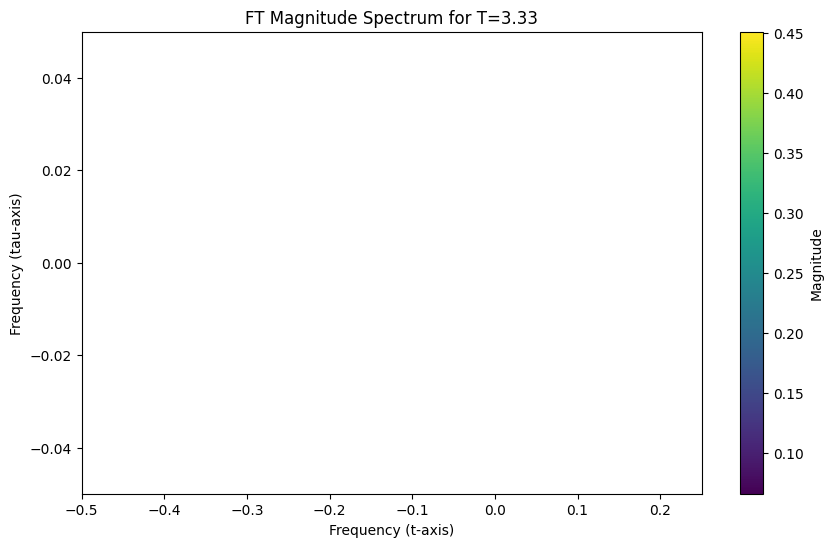

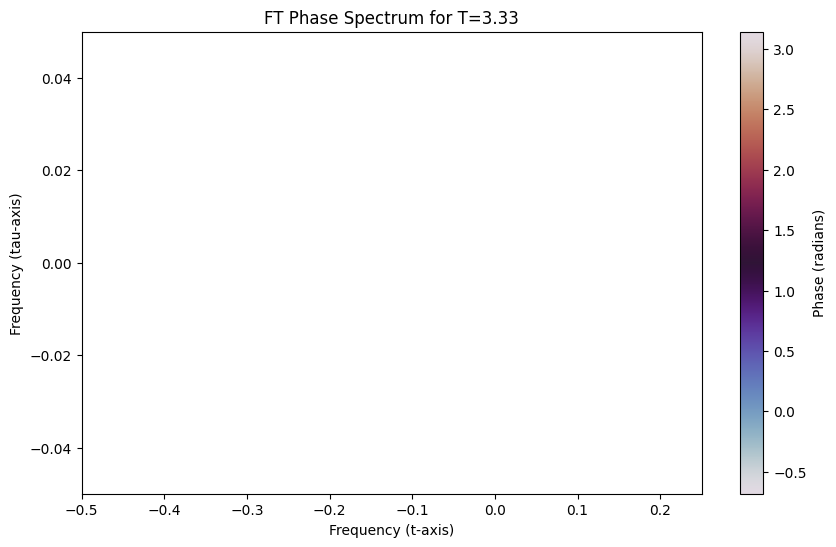

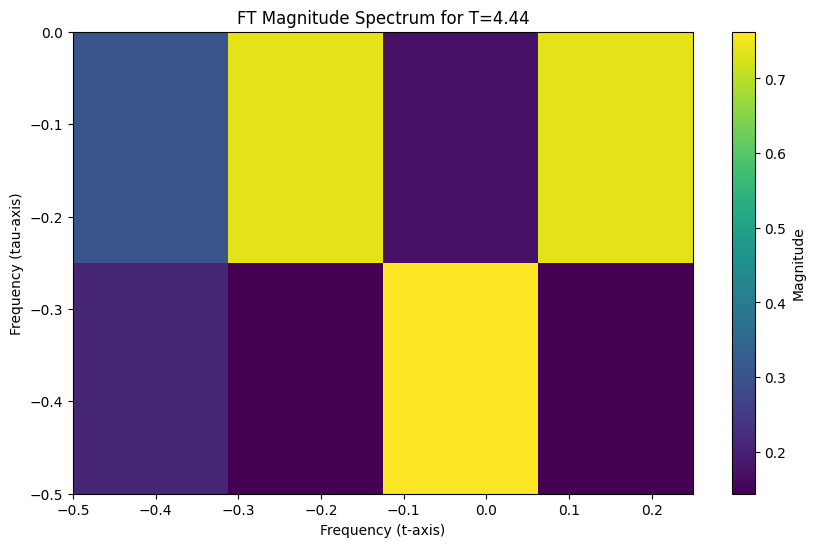

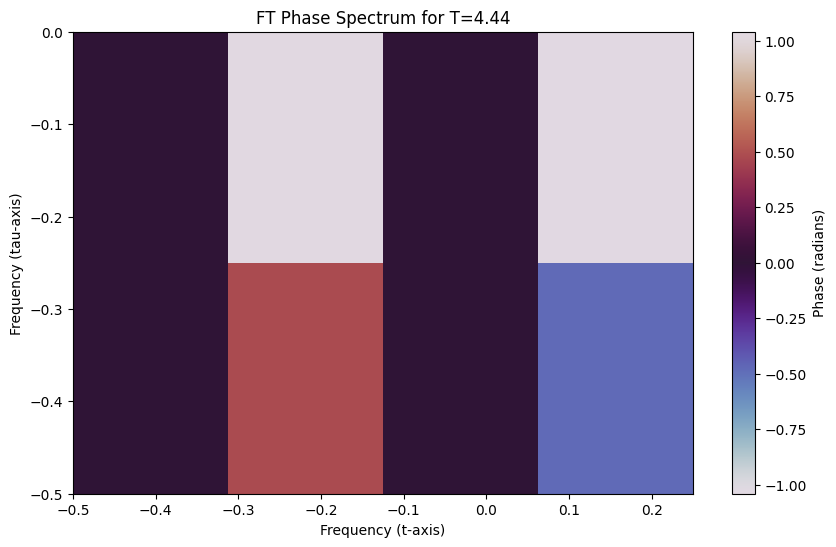

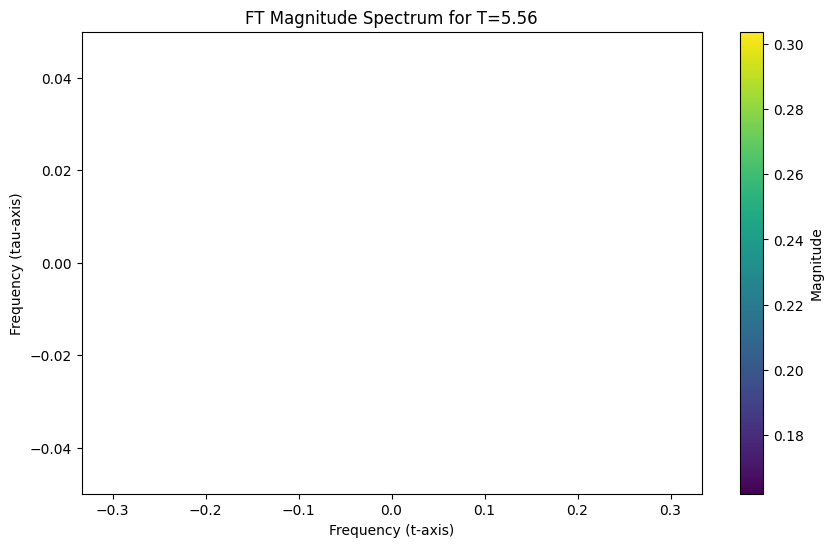

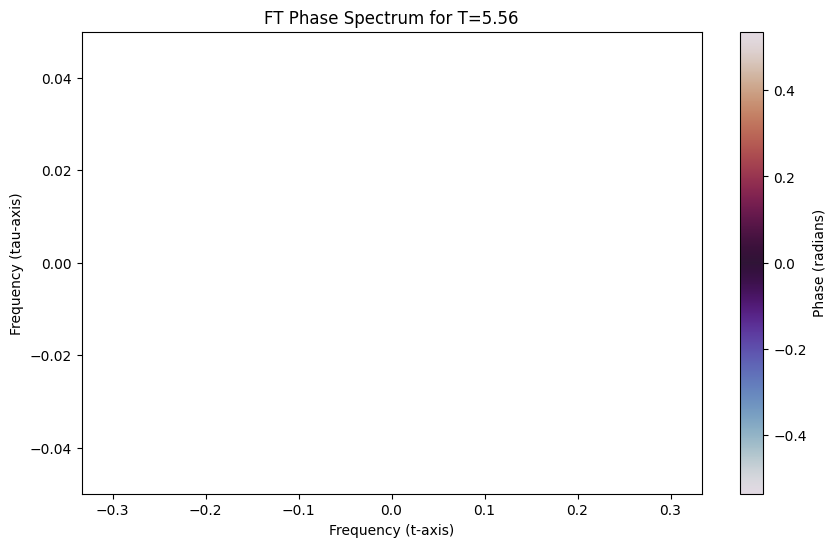

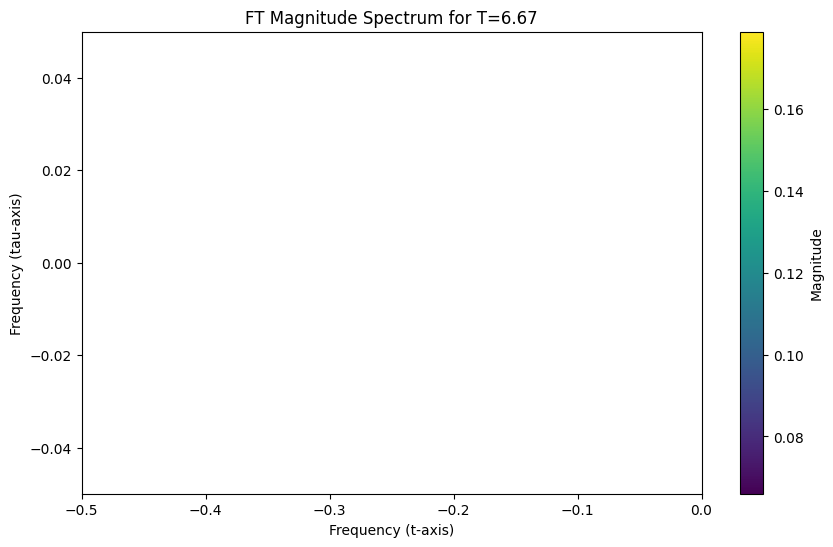

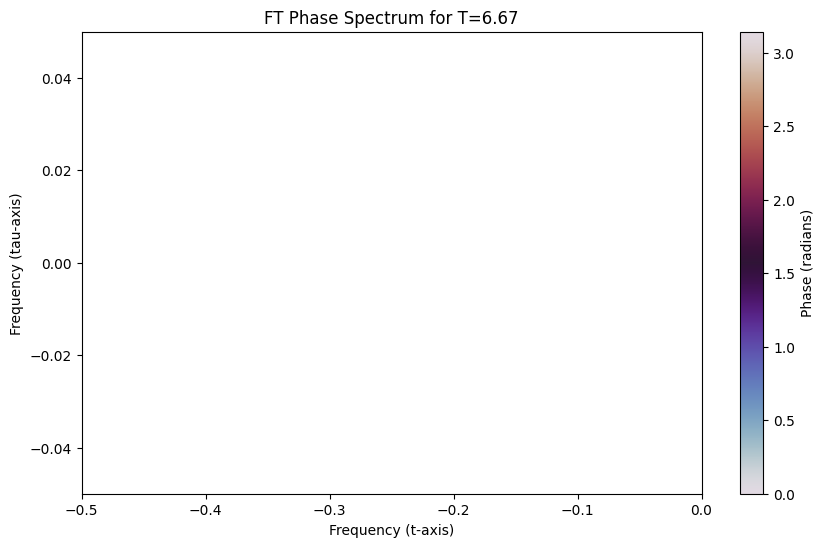

In [112]:
# Dictionary to store FT results
FT_results_dict = {}

# Perform 2D Fourier Transform for each T
for T, values_array in two_d_array_dict.items():
    # Compute the 2D Fast Fourier Transform
    FT_data = np.fft.fft2(values_array)  # Complex Fourier coefficients
    FT_magnitude = np.abs(FT_data)  # Magnitude spectrum
    FT_phase = np.angle(FT_data)  # Phase spectrum
    print(FT_data)
    # Compute frequency arrays for tau and t axes
    tau_len, t_len = values_array.shape
    tau_freqs = np.fft.fftfreq(tau_len)  # Frequency array for tau axis
    t_freqs = np.fft.fftfreq(t_len)  # Frequency array for t axis

    # Save the results in FT_results_dict
    FT_results_dict[T] = {
        'FT_data': FT_data,  # Complex FT result
        'FT_magnitude': FT_magnitude,  # Magnitude spectrum
        'FT_phase': FT_phase,  # Phase spectrum
        'tau_freqs': tau_freqs,  # Frequency array tau
        't_freqs': t_freqs  # Frequency array t
    }

# Visualization: Example for all T in FT_results_dict
for T, result in FT_results_dict.items():
    FT_magnitude = result['FT_magnitude']
    FT_phase = result['FT_phase']
    tau_freqs = result['tau_freqs']
    t_freqs = result['t_freqs']

    # Plot the Magnitude Spectrum
    plt.figure(figsize=(10, 6))
    plt.title(f'FT Magnitude Spectrum for T={T:.2f}')
    plt.imshow(
        np.fft.fftshift(FT_magnitude),  # Shift zero frequency to the center
        extent=[t_freqs.min(), t_freqs.max(), tau_freqs.min(), tau_freqs.max()],
        origin='lower',
        aspect='auto',
        cmap='viridis'
    )
    plt.xlabel('Frequency (t-axis)')
    plt.ylabel('Frequency (tau-axis)')
    plt.colorbar(label='Magnitude')
    plt.show()

    # Plot the Phase Spectrum (optional)
    plt.figure(figsize=(10, 6))
    plt.title(f'FT Phase Spectrum for T={T:.2f}')
    plt.imshow(
        np.fft.fftshift(FT_phase),  # Shift zero frequency to the center
        extent=[t_freqs.min(), t_freqs.max(), tau_freqs.min(), tau_freqs.max()],
        origin='lower',
        aspect='auto',
        cmap='twilight'
    )
    plt.xlabel('Frequency (t-axis)')
    plt.ylabel('Frequency (tau-axis)')
    plt.colorbar(label='Phase (radians)')
    plt.show()